---
subtitle: "Comparing Feature Extraction Methods and Classification Models for Pokémon Identification"
authors:
    - name: "Cameron Rich"
    - name: "Zach Buhai"
github: "https://github.com/CameronARich/whos-that-pokemon"
date: 2025-03-18
version: 2.3
---

# Who's That Pokémon?

## Introduction

Our aim for this project is as follows:

> Given a dataset of intergenerational Pokémon sprite images, can classification models reliably identify Pokémon, despite changes in art? Furthermore, which combination of classification models and extraction methods is the most accurate? How does the presence or absence of PCA affect model performance?

This notebook implements and compares three feature extraction techniques:

1. **HOG** _(Histogram of Oriented Gradients)_
2. **SIFT** _(Scale-Invariant Feature Transform)_
3. **Color Histogram**

Each technique is then trained and tested across three classification models:

1. **SVM** _(Support Vector Machines)_
2. **Random Forest**
3. **KNN** _(K-Nearest Neighbors)_

We test these both with and without PCA on the following Pokémon dataset: 

```bibtex
@misc{noodulz_pokemon,
  title = {The 1000 Pokemon Dataset},
  author = {Noodulz},
  year = {2023},
  url = {https://www.kaggle.com/datasets/noodulz/pokemon-dataset-1000/data},
}
```

# Import/Data Initialization

In [1]:
from pathlib import Path
import datetime
import gc
from PIL import Image
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Feature extraction libraries
from skimage.feature import hog
import cv2


DATA_DIR = Path("../../data/kaggle_data")
METADATA_PATH = DATA_DIR / "metadata.csv"
RESULTS_DIR = Path("..") / "results"
RESULTS_DIR.mkdir(exist_ok=True)


Metadata shape: (26539, 8)

First few rows:
       label                          image_path  hp  attack  defense  \
0  abomasnow   dataset/abomasnow/abomasnow_8.png  90      92       75   
1  abomasnow  dataset/abomasnow/abomasnow_18.png  90      92       75   
2  abomasnow  dataset/abomasnow/abomasnow_11.png  90      92       75   
3  abomasnow  dataset/abomasnow/abomasnow_16.png  90      92       75   
4  abomasnow   dataset/abomasnow/abomasnow_9.png  90      92       75   

   special-attack  special-defense  speed  
0              92               85     60  
1              92               85     60  
2              92               85     60  
3              92               85     60  
4              92               85     60  

Total number of unique Pokémon in full dataset: 1000

Subset metadata shape (800 random classes): (21102, 8)

Number of unique Pokémon in subset: 800
Average images per Pokémon (subset): 26.38
Min images for a Pokémon (subset): 6
Max images for a Pokém

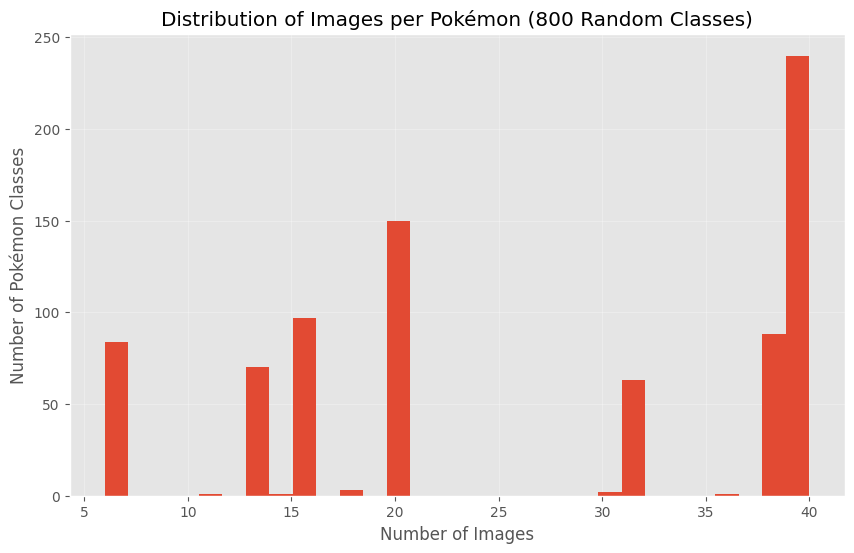

In [2]:
"""Load metadata.csv"""
metadata = pd.read_csv(METADATA_PATH)
print(f"Metadata shape: {metadata.shape}")
print("\nFirst few rows:")
print(metadata.head())

"""Get unique Pokémon classes (truncated to 800)"""
unique_pokemon = metadata["label"].unique()
print(f"\nTotal number of unique Pokémon in full dataset: {len(unique_pokemon)}")

selected_classes = np.random.choice(unique_pokemon, size=800, replace=False) 
# whoops. was tinkering with it as to not crash the kernel. forgot to fix this section?
# eventually landed on 750, as you will see. oh well. 50 truncated?
# not a big deal as there is no change in the split. not running it again for now.

"""Filter metadata for the selected classes"""
metadata_subset = metadata[metadata["label"].isin(selected_classes)]
print(f"\nSubset metadata shape (800 random classes): {metadata_subset.shape}")

"""Count unique Pokémon and their image distribution in the subset"""
unique_pokemon_subset = metadata_subset["label"].unique()
print(f"\nNumber of unique Pokémon in subset: {len(unique_pokemon_subset)}")

pokemon_counts_subset = metadata_subset["label"].value_counts()
print(f"Average images per Pokémon (subset): {pokemon_counts_subset.mean():.2f}")
print(f"Min images for a Pokémon (subset): {pokemon_counts_subset.min()}")
print(f"Max images for a Pokémon (subset): {pokemon_counts_subset.max()}")

"""Plot distribution for the subset"""
plt.figure(figsize=(10, 6))
plt.hist(pokemon_counts_subset, bins=30)
plt.title("Distribution of Images per Pokémon (800 Random Classes)")
plt.xlabel("Number of Images")
plt.ylabel("Number of Pokémon Classes")
plt.grid(alpha=0.3)
plt.show()

## Dataset Preview

To show examples of what we are working with, here's a visual preview of some of the images. 


Examples of abomasnow:


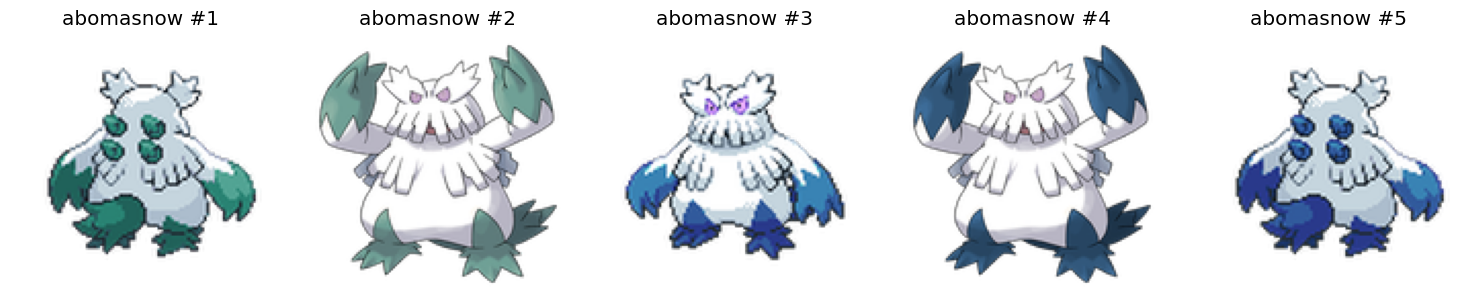


Examples of abra:


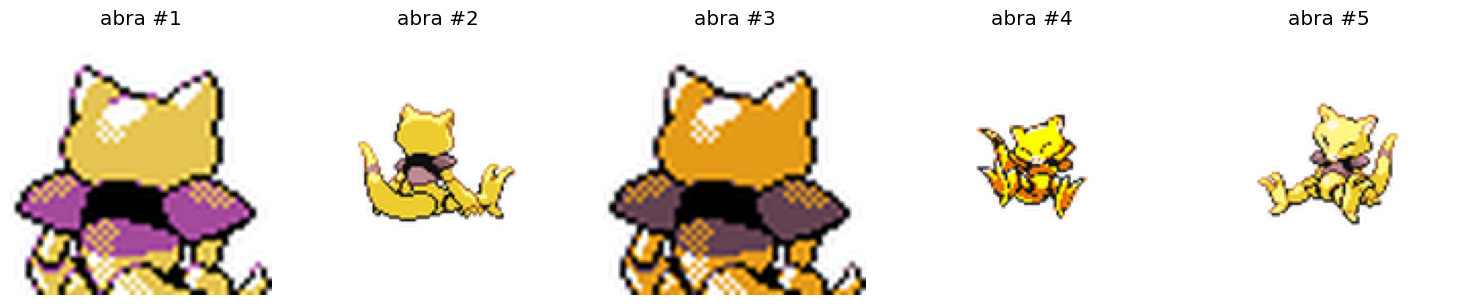


Examples of absol:


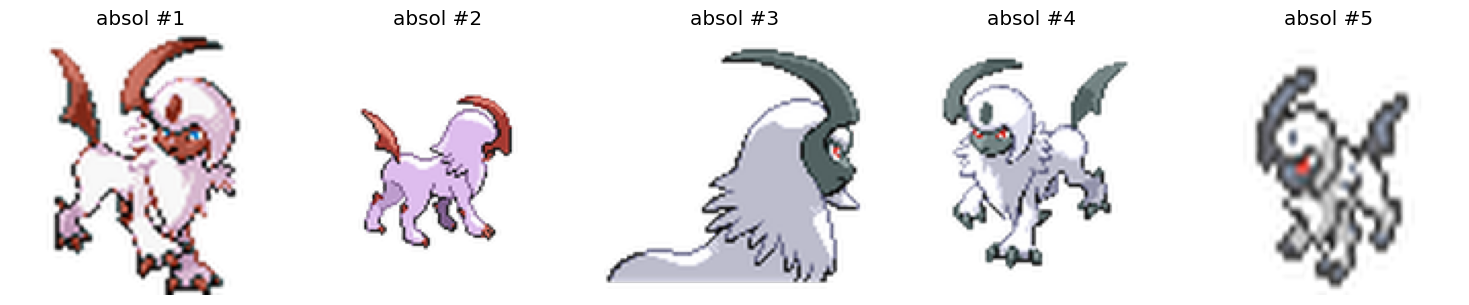

In [3]:
def display_pokemon_examples(pokemon_name, num_examples=5):
    """Get sample image paths for the given Pokémon"""
    pokemon_data = metadata[metadata['label'] == pokemon_name]
    sample_paths = pokemon_data['image_path'].sample(min(num_examples, len(pokemon_data))).values

    fig, axes = plt.subplots(1, len(sample_paths), figsize=(15, 3))
    if len(sample_paths) == 1:
        axes = [axes]
    for i, rel_path in enumerate(sample_paths):
        img_path = DATA_DIR / rel_path
        if img_path.exists():
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{pokemon_name} #{i+1}")
            axes[i].axis('off')
        else:
            print(f"Image not found: {img_path}")
    plt.tight_layout()
    plt.show()

"""Display examples of the first 3 Pokémon"""
for pokemon in unique_pokemon[:3]:
    print(f"\nExamples of {pokemon}:")
    display_pokemon_examples(pokemon)

# Dataset Preparation

We thin the dataset down a quarter (crashes otherwise) and prep it for training and testing.

In [5]:
# 750 random Pokémon
subset_metadata = metadata.copy()
all_classes = subset_metadata["label"].unique()
print(f"Total unique Pokémon classes available: {len(all_classes)}")

# Randomly sample 750 classes
sampled_classes = np.random.choice(all_classes, 750, replace=False)
print(f"Using {len(sampled_classes)} random classes.")

# Filter the metadata to include only the sampled classes
subset_metadata = subset_metadata[subset_metadata["label"].isin(sampled_classes)]
print(f"Using {len(subset_metadata)} images from the selected classes.")

# Encode labels
label_encoder = LabelEncoder()
subset_metadata["label_encoded"] = label_encoder.fit_transform(subset_metadata["label"])
encoder_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"First 5 class mappings: {list(encoder_mapping.items())[:5]}")

# Split the data
X_paths = subset_metadata["image_path"].values
y = subset_metadata["label_encoded"].values

X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    X_paths, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {len(X_train_paths)} images")
print(f"Testing set: {len(X_test_paths)} images")

# Create full paths
X_train_full = [DATA_DIR / p for p in X_train_paths]
X_test_full = [DATA_DIR / p for p in X_test_paths]

Total unique Pokémon classes available: 1000
Using 750 random classes.
Using 19707 images from the selected classes.
First 5 class mappings: [(0, 'abomasnow'), (1, 'abra'), (2, 'absol'), (3, 'accelgor'), (4, 'aegislash-shield')]
Training set: 15765 images
Testing set: 3942 images


# Feature Extraction

For each feature type (HOG, SIFT, Color Histogram), we extract features from the training and test sets. We perform extraction both with PCA and without PCA.

In [4]:
def extract_hog_features(
    image_path,
    target_size=(128, 128),
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    orientations=9,
):
    """Extract HOG features from an image."""
    try:
        img = Image.open(image_path).convert("RGB").resize(target_size)
        gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        return hog(
            gray,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm="L2-Hys",
            visualize=False,
        )
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


def extract_sift_features(image_path, target_size=(128, 128), n_features=128):
    """Extract SIFT features from an image."""
    try:
        img = Image.open(image_path).convert("RGB").resize(target_size)
        gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is None or len(descriptors) == 0:
            return np.zeros(n_features)
        avg_desc = np.mean(descriptors, axis=0)
        if len(avg_desc) > n_features:
            return avg_desc[:n_features]
        elif len(avg_desc) < n_features:
            return np.pad(avg_desc, (0, n_features - len(avg_desc)))
        else:
            return avg_desc
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


def extract_color_histogram_features(
    image_path, target_size=(128, 128), bins=(8, 8, 8)
):
    """Extract 3D color histogram features from an image."""
    try:
        img = Image.open(image_path).convert("RGB").resize(target_size)
        img_array = np.array(img)
        hist = cv2.calcHist(
            [img_array], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256]
        )
        return cv2.normalize(hist, hist).flatten()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


def extract_features_from_list(image_paths, feature_func, **kwargs):
    """Extract features (without PCA) from a list of image paths."""
    features, valid_paths = [], []
    for path in tqdm(image_paths):
        feat = feature_func(path, **kwargs)
        if feat is not None:
            features.append(feat)
            valid_paths.append(path)
    return np.array(features), valid_paths


def extract_features_with_pca(image_paths, feature_func, n_components=100, **kwargs):
    """Extract features and apply PCA."""
    features, valid_paths = extract_features_from_list(
        image_paths, feature_func, **kwargs
    )
    print(f"Applying PCA to reduce dimensions to {n_components} components...")
    pca = PCA(n_components=n_components)
    return pca.fit_transform(features), valid_paths, pca

In [6]:
print("Processing HOG features (No PCA) – Training")
hog_train_no_pca, valid_train_hog_no_pca = extract_features_from_list(
    X_train_full,
    extract_hog_features,
    target_size=(128, 128),
    pixels_per_cell=(16, 16),
    orientations=9,
)
y_train_hog_no_pca = [
    y_train[X_train_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_train_hog_no_pca
]

Processing HOG features (No PCA) – Training


In [7]:
print("Processing HOG features with PCA – Training")
hog_train_pca, valid_train_hog, pca_hog = extract_features_with_pca(
    X_train_full,
    extract_hog_features,
    n_components=100,
    target_size=(128, 128),
    pixels_per_cell=(16, 16),
    orientations=9,
)
y_train_hog = [
    y_train[X_train_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_train_hog
]

Processing HOG features with PCA – Training


Applying PCA to reduce dimensions to 100 components...


In [8]:
print("Processing HOG features for test set (No PCA)")
hog_test_no_pca, valid_test_hog_no_pca = extract_features_from_list(
    X_test_full,
    extract_hog_features,
    target_size=(128, 128),
    pixels_per_cell=(16, 16),
    orientations=9,
)
y_test_hog_no_pca = [
    y_test[X_test_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_test_hog_no_pca
]

print("Processing HOG features for test set (With PCA)")
hog_test = []
valid_test_hog = []
for path in tqdm(X_test_full):
    feat = extract_hog_features(
        path, target_size=(128, 128), pixels_per_cell=(16, 16), orientations=9
    )
    if feat is not None:
        hog_test.append(feat)
        valid_test_hog.append(path)
hog_test = np.array(hog_test)
hog_test_pca = pca_hog.transform(hog_test)
y_test_hog = [
    y_test[X_test_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_test_hog
]

Processing HOG features for test set (No PCA)


Processing HOG features for test set (With PCA)


In [9]:
print("Processing SIFT features (No PCA) – Training")
sift_train_no_pca, valid_train_sift_no_pca = extract_features_from_list(
    X_train_full, extract_sift_features, target_size=(128, 128), n_features=128
)
y_train_sift_no_pca = [
    y_train[X_train_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_train_sift_no_pca
]

Processing SIFT features (No PCA) – Training


In [10]:
print("Processing SIFT features with PCA – Training")
sift_train_pca, valid_train_sift, pca_sift = extract_features_with_pca(
    X_train_full,
    extract_sift_features,
    n_components=100,
    target_size=(128, 128),
    n_features=128,
)
y_train_sift = [
    y_train[X_train_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_train_sift
]

Processing SIFT features with PCA – Training


Applying PCA to reduce dimensions to 100 components...


In [11]:
print("Processing SIFT features for test set (No PCA)")
sift_test_no_pca, valid_test_sift_no_pca = extract_features_from_list(
    X_test_full, extract_sift_features, target_size=(128, 128), n_features=128
)
y_test_sift_no_pca = [
    y_test[X_test_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_test_sift_no_pca
]

print("Processing SIFT features for test set (With PCA)")
sift_test = []
valid_test_sift = []
for path in tqdm(X_test_full):
    feat = extract_sift_features(path, target_size=(128, 128), n_features=128)
    if feat is not None:
        sift_test.append(feat)
        valid_test_sift.append(path)
sift_test = np.array(sift_test)
sift_test_pca = pca_sift.transform(sift_test)
y_test_sift = [
    y_test[X_test_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_test_sift
]

Processing SIFT features for test set (No PCA)


Processing SIFT features for test set (With PCA)


In [12]:
print("Processing Color Histogram features (No PCA) – Training")
color_train_no_pca, valid_train_color_no_pca = extract_features_from_list(
    X_train_full,
    extract_color_histogram_features,
    target_size=(128, 128),
    bins=(8, 8, 8),
)
y_train_color_no_pca = [
    y_train[X_train_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_train_color_no_pca
]

Processing Color Histogram features (No PCA) – Training


In [13]:
print("Processing Color Histogram features with PCA – Training")
color_train_pca, valid_train_color, pca_color = extract_features_with_pca(
    X_train_full,
    extract_color_histogram_features,
    n_components=100,
    target_size=(128, 128),
    bins=(8, 8, 8),
)
y_train_color = [
    y_train[X_train_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_train_color
]

Processing Color Histogram features with PCA – Training


Applying PCA to reduce dimensions to 100 components...


In [14]:
print("Processing Color Histogram features for test set (No PCA)")
color_test_no_pca, valid_test_color_no_pca = extract_features_from_list(
    X_test_full,
    extract_color_histogram_features,
    target_size=(128, 128),
    bins=(8, 8, 8),
)
y_test_color_no_pca = [
    y_test[X_test_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_test_color_no_pca
]

print("Processing Color Histogram features for test set (With PCA)")
color_test = []
valid_test_color = []
for path in tqdm(X_test_full):
    feat = extract_color_histogram_features(
        path, target_size=(128, 128), bins=(8, 8, 8)
    )
    if feat is not None:
        color_test.append(feat)
        valid_test_color.append(path)
color_test = np.array(color_test)
color_test_pca = pca_color.transform(color_test)
y_test_color = [
    y_test[X_test_paths.tolist().index(str(path.relative_to(DATA_DIR)))]
    for path in valid_test_color
]

Processing Color Histogram features for test set (No PCA)


Processing Color Histogram features for test set (With PCA)


# Train/Evaluate Models

We now train three classifiers--SVM, Random Forest, and KNN--on the extracted features.

In [15]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_name="SVM", feature_type="HOG"):
    """Train a model and print evaluation metrics."""
    print(f"\n{model_name} with {feature_type} features:")
    if model_name == "SVM":
        model = SVC(probability=True, random_state=42)
    elif model_name == "RandomForest":
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "KNN":
        model = KNeighborsClassifier(n_neighbors=5)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    print("Training model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    target_names = [encoder_mapping[i] for i in np.unique(y_test)]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
    return model, accuracy

"""Dictionaries to store models and accuracies"""
models = {"HOG": {}, "SIFT": {}, "Color": {}}
accuracies = {"HOG": {}, "SIFT": {}, "Color": {}}
models_no_pca = {"HOG": {}, "SIFT": {}, "Color": {}}
accuracies_no_pca = {"HOG": {}, "SIFT": {}, "Color": {}}

In [16]:
for model_name in ["SVM", "RandomForest", "KNN"]:
    models["HOG"][model_name], accuracies["HOG"][model_name] = train_and_evaluate(
        hog_train_pca, y_train_hog, hog_test_pca, y_test_hog, model_name, "HOG (PCA)"
    )

del hog_train_pca, y_train_hog
gc.collect() 
# 46.67 GB RAM usage when these functions were in one cell. lmfao
# gotta be flushed manually now. no shot. 


SVM with HOG (PCA) features:
Training model...
Accuracy: 0.8179

Classification Report:
                            precision    recall  f1-score   support

                 abomasnow       1.00      1.00      1.00         8
                      abra       1.00      1.00      1.00         8
                     absol       0.80      1.00      0.89         8
                  accelgor       1.00      1.00      1.00         4
          aegislash-shield       1.00      0.67      0.80         3
                aerodactyl       0.75      0.38      0.50         8
                    aggron       1.00      1.00      1.00         8
                     aipom       0.89      1.00      0.94         8
                  alcremie       1.00      1.00      1.00         3
                 alomomola       0.60      0.75      0.67         4
                    amaura       1.00      0.67      0.80         3
                   ambipom       0.89      1.00      0.94         8
                 amoonguss

61

In [17]:
for model_name in ["SVM", "RandomForest", "KNN"]:
    models["SIFT"][model_name], accuracies["SIFT"][model_name] = train_and_evaluate(
        sift_train_pca,
        y_train_sift,
        sift_test_pca,
        y_test_sift,
        model_name,
        "SIFT (PCA)",
    )

del sift_train_pca, y_train_sift
gc.collect()


SVM with SIFT (PCA) features:
Training model...
Accuracy: 0.4257

Classification Report:
                            precision    recall  f1-score   support

                 abomasnow       0.67      1.00      0.80         8
                      abra       0.00      0.00      0.00         8
                     absol       0.31      0.62      0.42         8
                  accelgor       0.00      0.00      0.00         4
          aegislash-shield       0.00      0.00      0.00         3
                aerodactyl       0.00      0.00      0.00         8
                    aggron       0.14      0.38      0.21         8
                     aipom       0.25      0.25      0.25         8
                  alcremie       0.00      0.00      0.00         3
                 alomomola       0.50      0.50      0.50         4
                    amaura       1.00      0.33      0.50         3
                   ambipom       0.86      0.75      0.80         8
                 amoongus

44

In [18]:
for model_name in ["SVM", "RandomForest", "KNN"]:
    models["Color"][model_name], accuracies["Color"][model_name] = train_and_evaluate(
        color_train_pca,
        y_train_color,
        color_test_pca,
        y_test_color,
        model_name,
        "Color Histogram (PCA)",
    )

del color_train_pca, y_train_color
gc.collect()


SVM with Color Histogram (PCA) features:
Training model...
Accuracy: 0.0967

Classification Report:
                            precision    recall  f1-score   support

                 abomasnow       0.26      0.75      0.39         8
                      abra       0.00      0.00      0.00         8
                     absol       0.33      0.12      0.18         8
                  accelgor       0.00      0.00      0.00         4
          aegislash-shield       0.00      0.00      0.00         3
                aerodactyl       0.00      0.00      0.00         8
                    aggron       0.36      0.50      0.42         8
                     aipom       0.00      0.00      0.00         8
                  alcremie       0.00      0.00      0.00         3
                 alomomola       0.00      0.00      0.00         4
                    amaura       0.00      0.00      0.00         3
                   ambipom       0.16      0.50      0.24         8
              

44

In [19]:
for model_name in ["SVM", "RandomForest", "KNN"]:
    models_no_pca["HOG"][model_name], accuracies_no_pca["HOG"][model_name] = (
        train_and_evaluate(
            hog_train_no_pca,
            y_train_hog_no_pca,
            hog_test_no_pca,
            y_test_hog_no_pca,
            model_name,
            "HOG (No PCA)",
        )
    )

del hog_train_no_pca, y_train_hog_no_pca
gc.collect()


SVM with HOG (No PCA) features:
Training model...
Accuracy: 0.8212

Classification Report:
                            precision    recall  f1-score   support

                 abomasnow       1.00      1.00      1.00         8
                      abra       1.00      1.00      1.00         8
                     absol       0.89      1.00      0.94         8
                  accelgor       1.00      1.00      1.00         4
          aegislash-shield       1.00      0.67      0.80         3
                aerodactyl       0.50      0.38      0.43         8
                    aggron       1.00      1.00      1.00         8
                     aipom       1.00      1.00      1.00         8
                  alcremie       1.00      1.00      1.00         3
                 alomomola       0.75      0.75      0.75         4
                    amaura       1.00      0.67      0.80         3
                   ambipom       1.00      1.00      1.00         8
                 amoong

44

In [20]:
for model_name in ["SVM", "RandomForest", "KNN"]:
    models_no_pca["SIFT"][model_name], accuracies_no_pca["SIFT"][model_name] = (
        train_and_evaluate(
            sift_train_no_pca,
            y_train_sift_no_pca,
            sift_test_no_pca,
            y_test_sift_no_pca,
            model_name,
            "SIFT (No PCA)",
        )
    )

del sift_train_no_pca, y_train_sift_no_pca
gc.collect()


SVM with SIFT (No PCA) features:
Training model...
Accuracy: 0.1139

Classification Report:
                            precision    recall  f1-score   support

                 abomasnow       0.35      1.00      0.52         8
                      abra       0.00      0.00      0.00         8
                     absol       0.00      0.00      0.00         8
                  accelgor       0.00      0.00      0.00         4
          aegislash-shield       0.00      0.00      0.00         3
                aerodactyl       0.00      0.00      0.00         8
                    aggron       0.04      0.12      0.06         8
                     aipom       0.03      0.12      0.05         8
                  alcremie       0.00      0.00      0.00         3
                 alomomola       0.00      0.00      0.00         4
                    amaura       0.00      0.00      0.00         3
                   ambipom       0.17      0.38      0.23         8
                 amoon

44

In [21]:
for model_name in ["SVM", "RandomForest", "KNN"]:
    models_no_pca["Color"][model_name], accuracies_no_pca["Color"][model_name] = (
        train_and_evaluate(
            color_train_no_pca,
            y_train_color_no_pca,
            color_test_no_pca,
            y_test_color_no_pca,
            model_name,
            "Color Histogram (No PCA)",
        )
    )

del color_train_no_pca, y_train_color_no_pca
gc.collect()


SVM with Color Histogram (No PCA) features:
Training model...
Accuracy: 0.0665

Classification Report:
                            precision    recall  f1-score   support

                 abomasnow       0.19      0.75      0.30         8
                      abra       0.00      0.00      0.00         8
                     absol       0.00      0.00      0.00         8
                  accelgor       0.00      0.00      0.00         4
          aegislash-shield       0.00      0.00      0.00         3
                aerodactyl       0.00      0.00      0.00         8
                    aggron       0.20      0.25      0.22         8
                     aipom       1.00      0.12      0.22         8
                  alcremie       0.00      0.00      0.00         3
                 alomomola       0.00      0.00      0.00         4
                    amaura       0.00      0.00      0.00         3
                   ambipom       1.00      0.38      0.55         8
           

44

# Prediction Accuracy per Combination

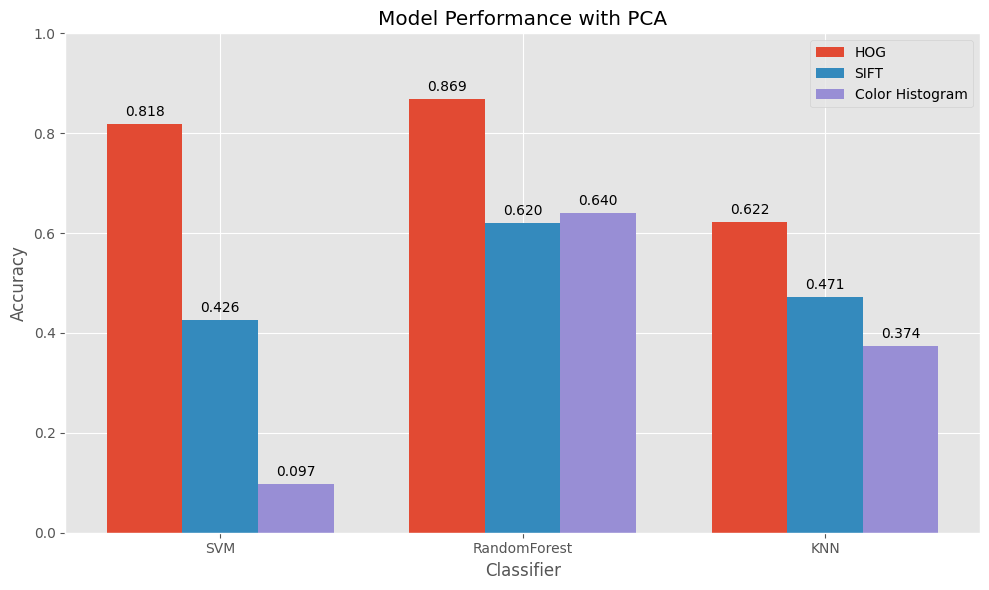

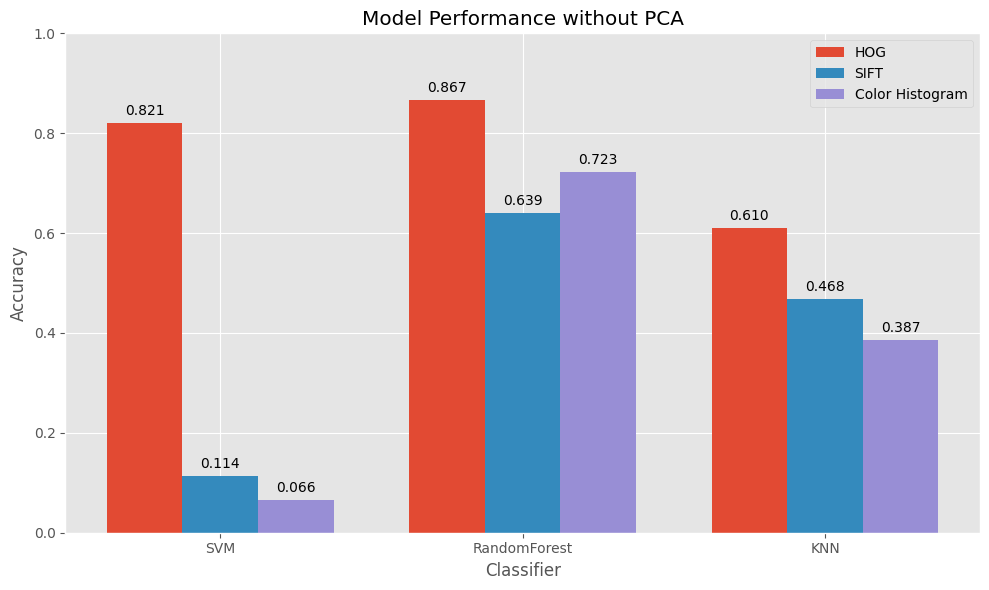

In [22]:
def plot_model_accuracies(acc_dict, title):
    model_names = list(acc_dict["HOG"].keys())
    hog_acc = [acc_dict["HOG"][m] for m in model_names]
    sift_acc = [acc_dict["SIFT"][m] for m in model_names]
    color_acc = [acc_dict["Color"][m] for m in model_names]

    bar_width = 0.25
    index = np.arange(len(model_names))
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(index - bar_width, hog_acc, bar_width, label="HOG")
    bars2 = ax.bar(index, sift_acc, bar_width, label="SIFT")
    bars3 = ax.bar(index + bar_width, color_acc, bar_width, label="Color Histogram")
    ax.set_xlabel("Classifier")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.set_xticks(index)
    ax.set_xticklabels(model_names)
    ax.legend()
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width()/2.0, bar.get_height() + 0.01, f"{bar.get_height():.3f}",
                    ha="center", va="bottom")
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

plot_model_accuracies(accuracies, "Model Performance with PCA")
plot_model_accuracies(accuracies_no_pca, "Model Performance without PCA")


# Confusion Matrix and Classification Visualization

Results with PCA for best feature HOG using RandomForest


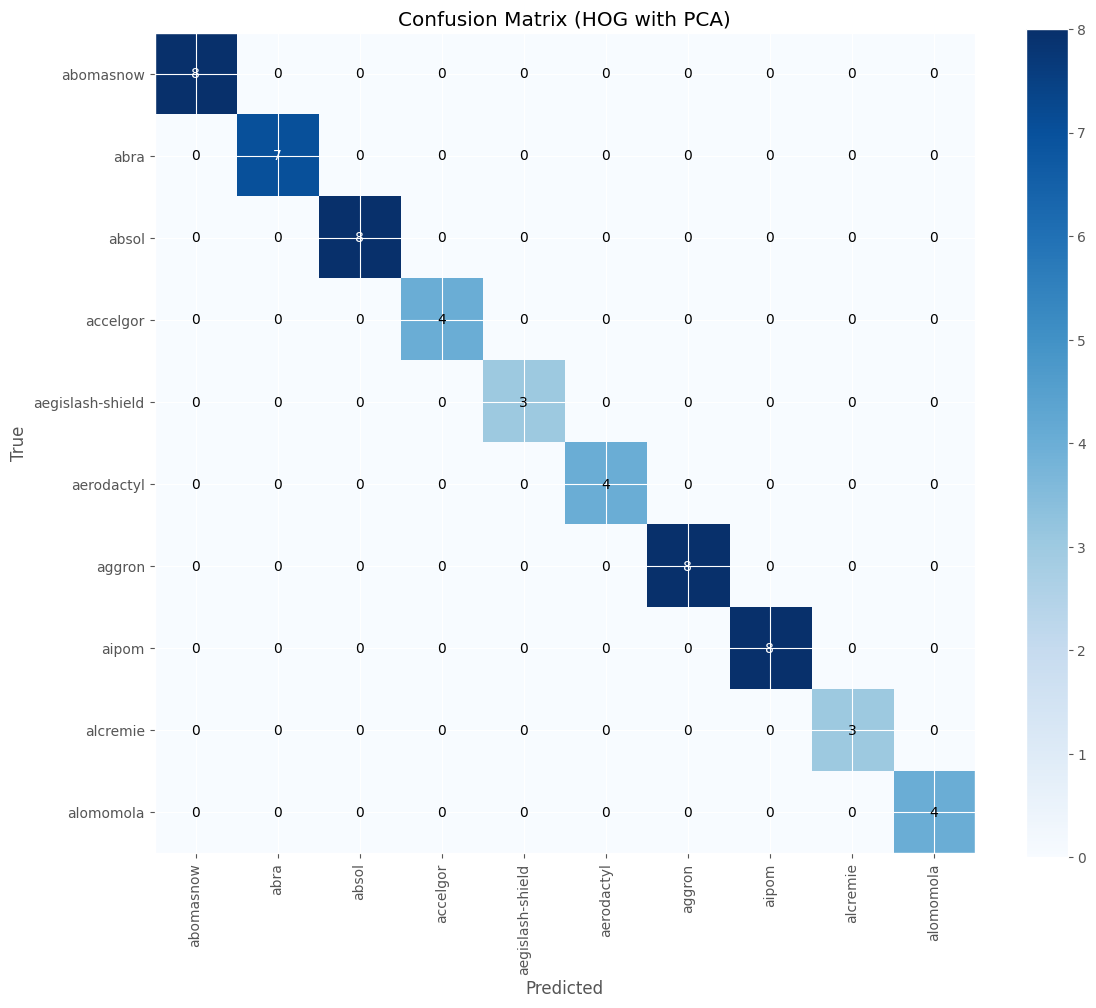

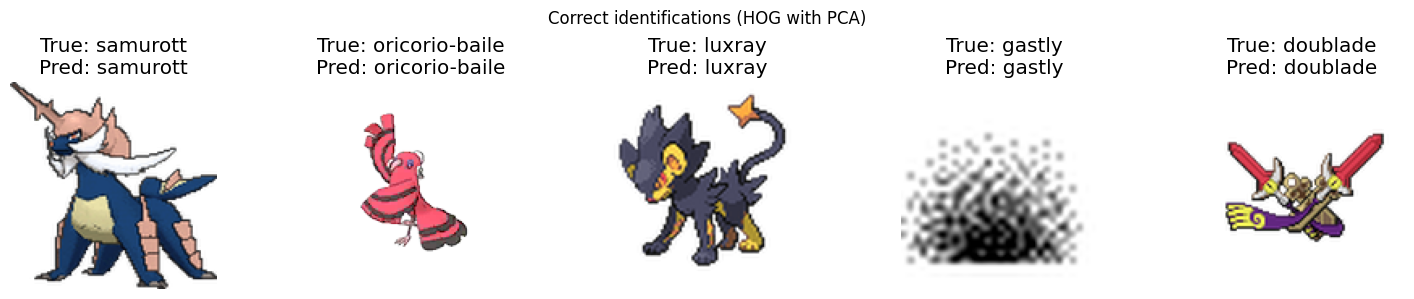

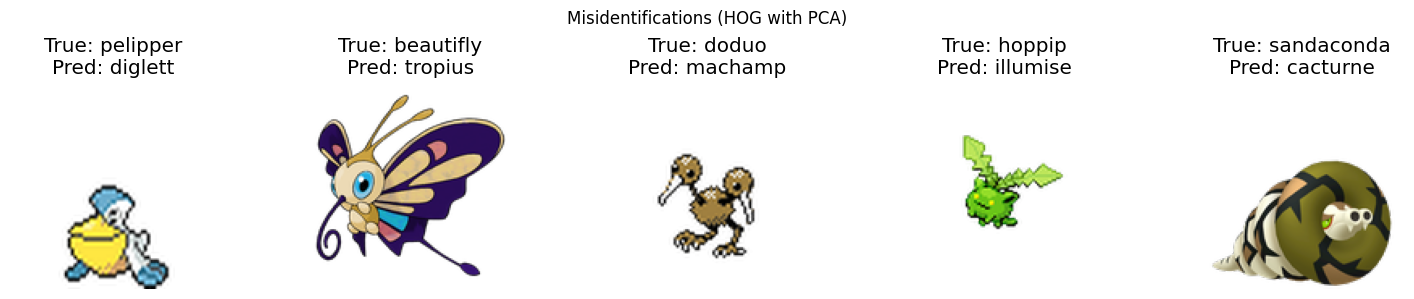


Results without PCA for best feature HOG using RandomForest


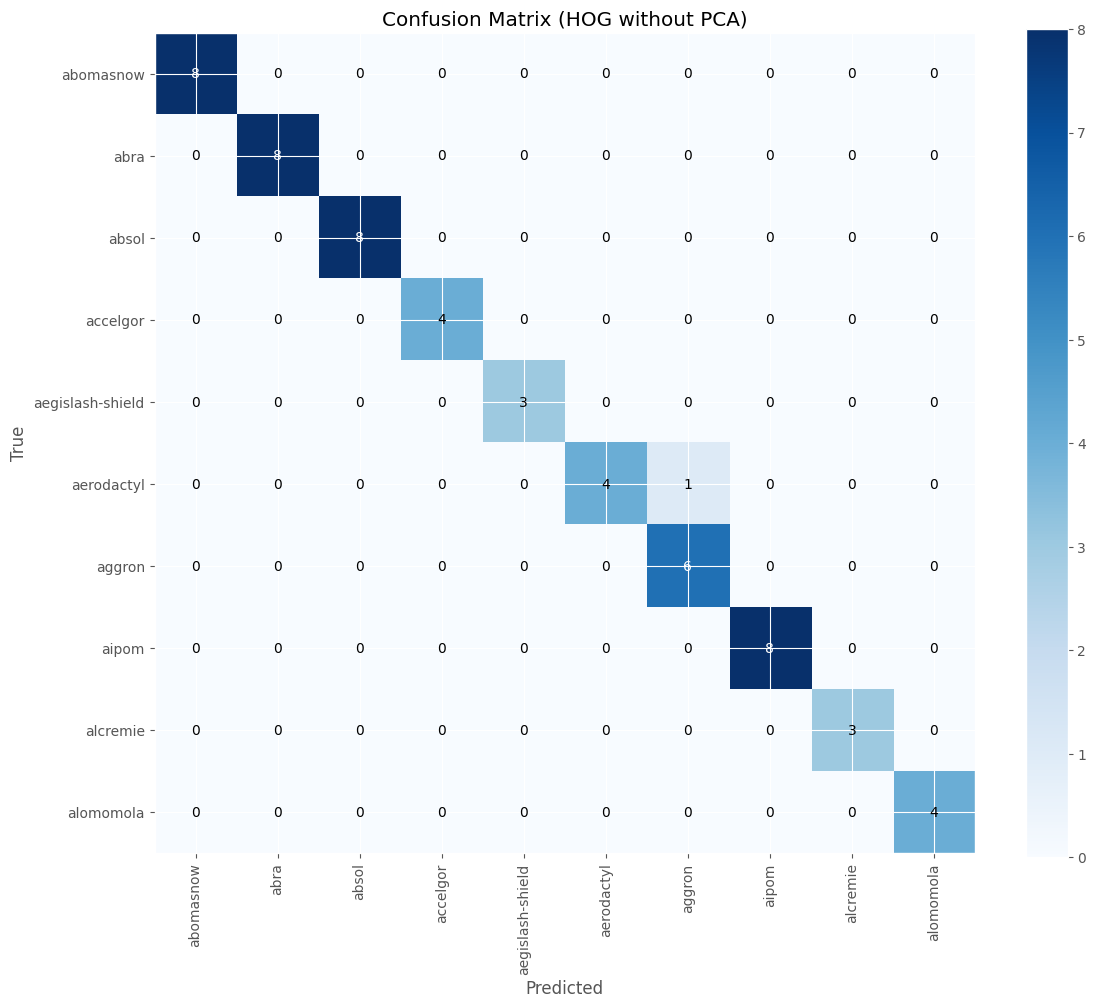

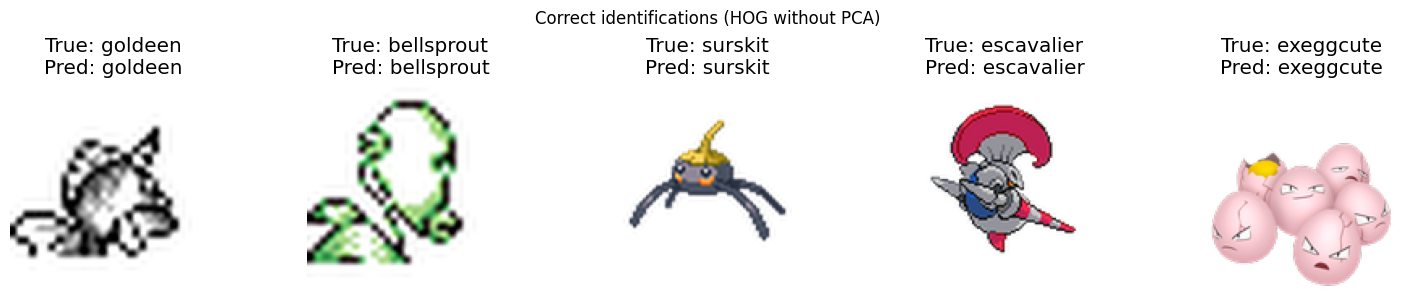

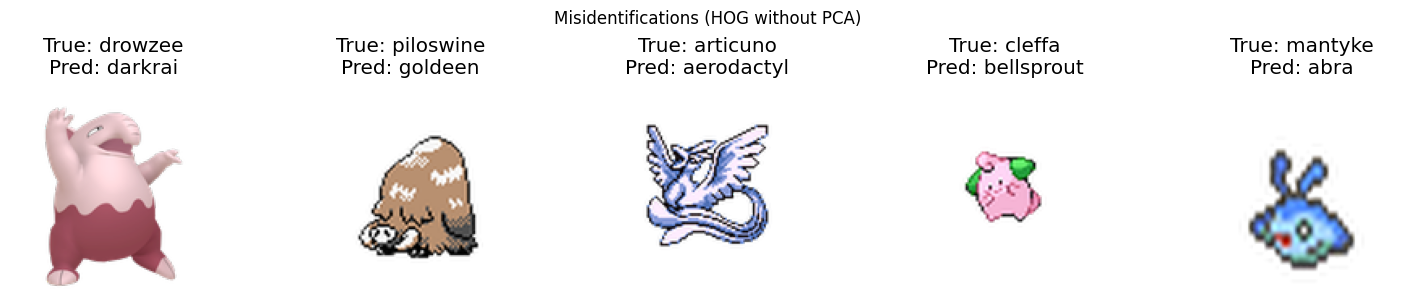

In [25]:
def plot_confusion_matrix(y_true, y_pred, title, top_classes=10):
    """Plots a confusion matrix given a true and predicted array of labels."""
    cm = confusion_matrix(y_true, y_pred)
    class_names = [encoder_mapping[i] for i in range(top_classes)]
    cm_subset = cm[
        :top_classes, :top_classes
    ]  # probably should have randomized but too late
    plt.figure(figsize=(12, 10))
    plt.imshow(cm_subset, cmap="Blues")
    plt.colorbar()
    plt.title(title)
    plt.xticks(range(top_classes), class_names, rotation=90)
    plt.yticks(range(top_classes), class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(top_classes):
        for j in range(top_classes):
            plt.text(
                j,
                i,
                cm_subset[i, j],
                ha="center",
                va="center",
                color="white" if cm_subset[i, j] > cm_subset.max() / 2 else "black",
            )
    plt.tight_layout()
    plt.show()


best_model_type = "RandomForest"
best_model_type_no_pca = "RandomForest"
best_feature = "HOG"
best_feature_no_pca = "HOG"


def display_image_examples(y_true, y_pred, image_paths, title, n_examples=5):
    indices = np.arange(len(y_true))
    if len(indices) > n_examples:
        selected = np.random.choice(indices, n_examples, replace=False)
    else:
        selected = indices
    fig, axes = plt.subplots(1, len(selected), figsize=(15, 3))
    if len(selected) == 1:
        axes = [axes]
    for i, idx in enumerate(selected):
        img = Image.open(image_paths[idx])
        true_label = encoder_mapping[y_true[idx]]
        pred_label = encoder_mapping[y_pred[idx]]
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def display_misclassified_examples(y_true, y_pred, image_paths, title, n_examples=5):
    """Display examples of misclassified images."""
    misclassified_indices = np.where(y_true != y_pred)[0]

    if len(misclassified_indices) == 0:
        print("No misclassifications found.")
        return

    if len(misclassified_indices) > n_examples:
        selected = np.random.choice(misclassified_indices, n_examples, replace=False)
    else:
        selected = misclassified_indices

    fig, axes = plt.subplots(1, len(selected), figsize=(15, 3))
    if len(selected) == 1:
        axes = [axes]

    for i, idx in enumerate(selected):
        img = Image.open(image_paths[idx])
        true_label = encoder_mapping[y_true[idx]]
        pred_label = encoder_mapping[y_pred[idx]]
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


print(f"Results with PCA for best feature {best_feature} using {best_model_type}")

if best_feature == "HOG":
    best_model = models["HOG"][best_model_type]
    best_test_features = hog_test_pca
    best_y_test = y_test_hog
    valid_test_images = [str(p) for p in valid_test_hog]
elif best_feature == "SIFT":
    best_model = models["SIFT"][best_model_type]
    best_test_features = sift_test_pca
    best_y_test = y_test_sift
    valid_test_images = [str(p) for p in valid_test_sift]
else:
    best_model = models["Color"][best_model_type]
    best_test_features = color_test_pca
    best_y_test = y_test_color
    valid_test_images = [str(p) for p in valid_test_color]

best_preds = best_model.predict(best_test_features)
plot_confusion_matrix(
    best_y_test, best_preds, f"Confusion Matrix ({best_feature} with PCA)"
)

display_image_examples(
    best_y_test,
    best_preds,
    valid_test_images,
    f"Correct identifications ({best_feature} with PCA)",
    n_examples=5,
)
display_misclassified_examples(
    best_y_test,
    best_preds,
    valid_test_images,
    f"Misidentifications ({best_feature} with PCA)",
    n_examples=5,
)


print(
    f"\nResults without PCA for best feature {best_feature_no_pca} using {best_model_type_no_pca}"
)

if best_feature_no_pca == "HOG":
    best_model_no_pca = models_no_pca["HOG"][best_model_type_no_pca]
    best_test_features_no_pca = hog_test_no_pca
    best_y_test_no_pca = y_test_hog_no_pca
    valid_test_images_no_pca = [str(p) for p in valid_test_hog_no_pca]
elif best_feature_no_pca == "SIFT":
    best_model_no_pca = models_no_pca["SIFT"][best_model_type_no_pca]
    best_test_features_no_pca = sift_test_no_pca
    best_y_test_no_pca = y_test_sift_no_pca
    valid_test_images_no_pca = [str(p) for p in valid_test_sift_no_pca]
else:
    best_model_no_pca = models_no_pca["Color"][best_model_type_no_pca]
    best_test_features_no_pca = color_test_no_pca
    best_y_test_no_pca = y_test_color_no_pca
    valid_test_images_no_pca = [str(p) for p in valid_test_color_no_pca]

best_preds_no_pca = best_model_no_pca.predict(best_test_features_no_pca)
plot_confusion_matrix(
    best_y_test_no_pca,
    best_preds_no_pca,
    f"Confusion Matrix ({best_feature_no_pca} without PCA)",
)

display_image_examples(
    best_y_test_no_pca,
    best_preds_no_pca,
    valid_test_images_no_pca,
    f"Correct identifications ({best_feature_no_pca} without PCA)",
    n_examples=5,
)
display_misclassified_examples(
    best_y_test_no_pca,
    best_preds_no_pca,
    valid_test_images_no_pca,
    f"Misidentifications ({best_feature_no_pca} without PCA)",
    n_examples=5,
)

# Data Export

To save the data, we're exporting it as a CSV in case of further inquiry.

In [24]:
def compute_per_class_accuracy(y_true, y_pred):
    """Compute per-class accuracy and return a dictionary mapping class index to accuracy."""
    classes = np.unique(y_true)
    return {cls: np.mean(y_pred[np.where(y_true == cls)] == y_true[np.where(y_true == cls)])
            for cls in classes}

results = {}
# PCA
for feat, model_dict in zip(["HOG", "SIFT", "Color"], [models, models, models]):
    for model_name in model_dict[feat]:
        combo = f"{feat}_PCA_{model_name}"
        if feat == "HOG":
            preds = models[feat][model_name].predict(hog_test_pca)
            results[combo] = compute_per_class_accuracy(np.array(y_test_hog), preds)
        elif feat == "SIFT":
            preds = models[feat][model_name].predict(sift_test_pca)
            results[combo] = compute_per_class_accuracy(np.array(y_test_sift), preds)
        else:
            preds = models[feat][model_name].predict(color_test_pca)
            results[combo] = compute_per_class_accuracy(np.array(y_test_color), preds)

# no PCA
for feat, model_dict in zip(["HOG", "SIFT", "Color"], [models_no_pca, models_no_pca, models_no_pca]):
    for model_name in model_dict[feat]:
        combo = f"{feat}_noPCA_{model_name}"
        if feat == "HOG":
            preds = models_no_pca[feat][model_name].predict(hog_test_no_pca)
            results[combo] = compute_per_class_accuracy(np.array(y_test_hog_no_pca), preds)
        elif feat == "SIFT":
            preds = models_no_pca[feat][model_name].predict(sift_test_no_pca)
            results[combo] = compute_per_class_accuracy(np.array(y_test_sift_no_pca), preds)
        else:
            preds = models_no_pca[feat][model_name].predict(color_test_no_pca)
            results[combo] = compute_per_class_accuracy(np.array(y_test_color_no_pca), preds)

classes_sorted = sorted(encoder_mapping.keys())
class_names = [encoder_mapping[i] for i in classes_sorted]
df_results = pd.DataFrame({combo: [acc.get(cls, np.nan) for cls in classes_sorted] for combo, acc in results.items()},
                          index=class_names)
df_results = df_results.sort_index(axis=1)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = RESULTS_DIR / f"results_{timestamp}.csv"
df_results.to_csv(csv_filename)
print(f"Results exported to {csv_filename}")

Results exported to ../results/results_20250318_051449.csv


# Findings

1. Across both PCA and non-PCA, Random Forest/HOG is the most accurate combination--it essentially hits five out of six shots, so it can rather reliably identify Pokémon.
2. The presence or absence of PCA is largely intangible, except for:
   - SIFT/SVM, in which case the absence of PCA craters its accuracy ~75%.
   - Color/SVM, in which case it loses about a third of its diminished accuracy.
   - Color/RandForest, in which case it gains .08 accuracy.
3. 
4. ~~Python kernels can balloon up to 48 gigabytes of RAM usage with no discernable performance degradation on your computer whilst so?~~

# Further Research

With regards to methodology:
1. Test specific generations/games against each other directly?
2. Working with masks to replicate the "Who's That Pokemon" eyecatch?

With regards to data curation, testing:
1. Official Ken Sugimori renders
2. Arbitrary angle renders of Pokémon in 3D
3. Arbitrary screenshots of Pokémon in-game
4. Anime stills
5. Merchandise photos